# Cultural Patterns
## Assignment 2
### 1)

How do indie musicians use visual signs to indicate their subgenre?

### 2)

This exploration will work by gathering album covers from bandcamp. 

Running `bandcamp_webtools.py` will generate the `./covers` folder and populate it with files which use
the builtin `pickle` format. Each file has an album cover, and information about that release. This particular
analysis uses 1100+ albums from 400+ artists, with a total size of ~ 4 GB. For a final project better data management methods
are needed. I will try to write methods which will work at arbitrary scales for today.

`bandcamp_webtools.py` has two main functions, `cowdog` and `get_album_covers`. `Cowdog` takes in an input bandcamp album
and goes through the recommendation links to find a tree of related albums. Then it takes the store id for those albums
and records it to `artist_tags`. For this exploration, that input is https://chillhop.bandcamp.com/track/velocities. The
point of this is to discover new bandcamp stores without having to go off of a reference sheet, or use bandcamp's search
function.  

`get_album_covers` takes each of the store ids that we gathered with `cowdog` and goes through that store scraping
every album cover in that store. It also records the artist name, and the tags that the store has provided for the album.
The function stores them in a `./covers` folder using the builtin `pickle` format. `pickle` is a high efficiency way to
store python objects for later use.

Due to the size of data and the difficulty of webscraping, this investigation will just look at the "Hip-Hop" genre and 
an associated subgenre "Chillhop".

### 3)
The first thing we need to do is load the album covers into memory.

In [133]:
import pandas as pd
import numpy as np
import pickle
import os
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns
import scipy
from PIL import Image
import scipy.misc
import scipy.cluster
import struct
import binascii
import colorgram
import colorsys

In [2]:
data_dict = {}
for file in tqdm(os.listdir('./covers')):
    with open('./covers/' + file, 'br') as jar:
        try:
            album_info = pickle.load(jar)
        except EOFError:  # One of the files is empty...
            continue
        for key in album_info:
            try:
                data_dict[key].append(album_info[key])
            except KeyError:
                data_dict[key] = [album_info[key]]

100%|██████████| 1142/1142 [00:42<00:00, 26.58it/s]


In [4]:
data = pd.DataFrame.from_dict(data_dict)

In [5]:
data.head()

,cover,title,artist,tags,album,url,store
0,"[[[3, 2, 7], [0, 0, 4], [7, 6, 11], [1, 1, 3],...",Breathe,white lights,"[electronic, r&b, r&b/soul, antipop, experimen...",breathe,https://whitelights.bandcamp.com/track/breathe,whitelights
1,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",Dual​-​Brained¹,white lights,"[electronic, r&b, r&b/soul, antipop, experimen...",dual-brained,https://whitelights.bandcamp.com/album/dual-br...,whitelights
2,"[[[213, 190, 172], [213, 190, 172], [213, 190,...",rhodes less travelled,fortnight,"[hip-hop/rap, beats, cassette, instrumental, j...",rhodes-less-travelled,https://lo-factory.bandcamp.com/album/rhodes-l...,lo-factory
3,"[[[121, 66, 45], [106, 75, 46], [98, 73, 42], ...",Gaia,Axian,"[hip hop, hip-hop/rap, jazz fusion, chill, chi...",gaia,https://chillhop.bandcamp.com/album/gaia,chillhop
4,"[[[48, 34, 59], [55, 41, 66], [58, 44, 69], [5...",Rosewood,harris cole x arbour,"[hip hop, hip-hop/rap, jazz fusion, chill, chi...",rosewood,https://chillhop.bandcamp.com/track/rosewood,chillhop


### 4)

In [20]:
def make_colorgram(image_array, n=6):
    img = Image.fromarray(image_array)
    cs = colorgram.extract(img, n)
    cs = [[color.rgb for color in cs]]
    return cs  # This code uses the colorgram package to get the 'dominant' colors from each image.

cgrams = []

for cover in tqdm(data['cover']):
    try:
        cgrams.append(np.array(make_colorgram(cover, 4)))
    except TypeError:
        cgrams.append(None)

data['cgram'] = cgrams

In [25]:
with open('data_store.pkl', 'bw') as f:
    pickle.dump(data, f)

The code above uses the `colorgram` package to decompose each image into 4 dominant tones. Those are then stored as
rgb arrays in the data frame. I then pickled it for safe-keeping.

In [28]:
data = data.drop('cover', axis=1) # For ram reasons.

In [120]:
def get_tag_cols(tag):
    tagged = data.iloc[[tag in tags for tags in data['tags']]]
    cols = tagged['cgram'].reset_index(drop=True)
    return cols

chill_cols = get_tag_cols('chillhop')

In [171]:
def brightness_plot(cols, tag):
    brightnesses = [(0.299*r + 0.587*g + 0.114*b)  for gram in cols for col in gram for r, g, b in col]
    brightnesses = np.array(brightnesses)
    rs, gs, bs = zip(*[[r, g, b]  for gram in cols for col in gram for r, g, b in col])
    
    sns.distplot(brightnesses, color='black', hist=False)
    sns.distplot(rs, color='red', hist=False)
    sns.distplot(bs, color='blue', hist=False)
    sns.distplot(gs, color='green', hist=False).set_title(f'Brightness plot for {tag}-tagged album covers.')
    plt.show()

In [172]:
def luminance(color):
    r, g, b = color
    return 0.299*r + 0.587*g + 0.114*b

def col_plot(cols, tag, size=48):
    colors_unorganized = np.array(sorted([col for box in cols for img in box for col in img], 
                                         key=lambda rgb: colorsys.rgb_to_hls(*rgb)))
    colors_unorganized.resize(size * size * 3)
    colors_unorganized = colors_unorganized.reshape((size, -1, 3))
    colors_unorganized = colors_unorganized
    plt.matshow(colors_unorganized)
    plt.title(f'Color Plot for {tag}-tagged album covers.')
    plt.show()

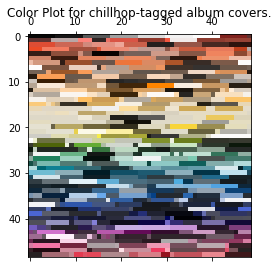

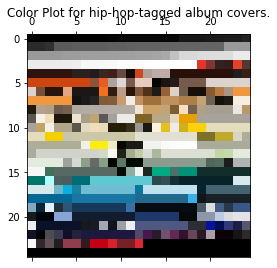

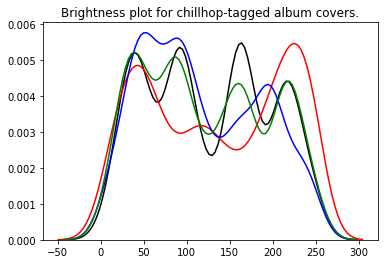

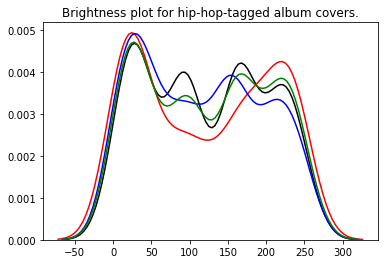

In [177]:
hhcols = get_tag_cols('hip-hop')
lfcols = get_tag_cols('lo-fi')


col_plot(chill_cols, 'chillhop', 49)
col_plot(hhcols, 'hip-hop', 25)
brightness_plot(chill_cols, 'chillhop')
brightness_plot(hhcols, 'hip-hop')

For reference, the Color plots show the dominant colors of each album, which have been sorted by Hue, Luminosity, and
Saturation, and then arranged in a square. This is a good, at-a-glance way to compare palettes. The brightness plots 
show the distribution of four values. The red line shows the distribution of red-channel colors in the dominant color
charts, green for the brightness of the green channel, and blue for the blue channel. The black line shows the
brightness according to the quick-luminosity formula:

$$ 0.299r + 0.587g + 0.114b $$

The biggest trends we see are that albums tagged as 'chillhop' favor pastels, we see almost no vibrant colors in the
makeup. When compared with album covers tagged as members of the parent genre, hip-hop. Hip-Hop favors high saturation reds, high contrasts between whites, grays and blacks, and rarely uses yellows and greens. Chillhop however is dominated by soft warm colors and medium cool colors. High saturation colors don't even appear in the Chillhop color plot. The soft colors in chillhop album covers are often there to give the viewer the sense that what they're about to listen to will be relaxing and pleasant. This stands in contrast to the more serious parent genre hip-hop which is often trying to give the listener the sense that their album is to be taken seriously, and for rap albums that the artist may be trying to make a point about something. For example Rap music for social activism is very popular on bandcamp, but you'd be hard-pressed to find any of these artists who would self-identify as chillhop artists.

The brightness plots show us more interesting findings. For one, the luminescence tends to be lower for hip-hop than chillhop. This aligns with the cultural feeling that chillhop is not for serious point making, or high emotion, it's intended to be light and relaxing. 

### 5)

Next steps for me would be to look for similar patterns in other genres and subgenres. For example, we can look at the subgenre 'acoustic alternative' in contrast with the parent genre 'alternative'. This is a place where we'd expect to see similar patterns, with greater use of earth tones in the acoustic albums and more harsh colors in the alternative albums. Due to the scope of this assignment, I couldn't really dig into these, nor construct an automated way to compare tags to one another. This is mainly due to the fact that it's infeasible to load more than 5 GB of data into my laptop's RAM at a time, but if I construct metrics for comparing albums to one another (like the dominant color charts) this limitation can be avoided. I think that constructing better analysis methods is the best way to examine these patterns. I'd also like to run the album covers through google-cloud-vision to see if there are recurring iconography in the genres of interest. All of the artists that this analysis used were within 5 links of 'chillhop.bandcamp.com' as well, which could be problematic for comparison purposes. With more time it would be feasible to enter a couple of starting points and gather a more diverse list of artists.